### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for Atari [Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) that uses a recurrent neural net.

![https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week08_pomdp/atari_util.py

        !touch .setup_complete

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

For starters, let's take a look at the game itself:

* Image resized to 42x42 and converted to grayscale to run faster
* Agent sees last 4 frames of game to account for object velocity

In [ ]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

In [ ]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

### Simple agent for fully-observable MDP

Here's a code for an agent that only uses feedforward layers. Please read it carefully: you'll have to extend it later!

In [ ]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
from keras.layers import Conv2D, Dense, Flatten


class FeedforwardAgent:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv2 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.flatten = Flatten()
            self.hid = Dense(128, activation='elu')
            self.logits = Dense(n_actions)
            self.state_value = Dense(1)

            # prepare a graph for agent step
            _initial_state = self.get_initial_state(1)
            self.prev_state_placeholders = [
                tf.placeholder(m.dtype, [None] + [m.shape[i] for i in range(1, m.ndim)])
                for m in _initial_state
            ]
            self.obs_t = tf.placeholder('float32', [None, ] + list(obs_shape))
            self.next_state, self.agent_outputs = self.symbolic_step(self.prev_state_placeholders, self.obs_t)

    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""

        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)
        logits = self.logits(nn)
        state_value = self.state_value(nn)

        # feedforward agent has no state
        new_state = []

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        # feedforward agent has no state
        return []

    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        feed_dict = {self.obs_t: obs_t}
        for state_ph, state_value in zip(self.prev_state_placeholders, prev_state):
            feed_dict[state_ph] = state_value
        return sess.run([self.next_state, self.agent_outputs], feed_dict)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [ ]:
n_parallel_games = 5
gamma = 0.99

agent = FeedforwardAgent("agent", obs_shape, n_actions)

sess.run(tf.global_variables_initializer())

In [ ]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

### Let's play!
Let's build a function that measures agent's average reward.

In [ ]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(
                prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    rewards = evaluate(agent, env_monitor, n_games=3)

print(rewards)

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://s7.postimg.cc/4y36s2b2z/env_pool.png)

In [ ]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [ ]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [ ]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 42, 42, 1)


# Actor-critic

Here we define a loss function that uses rollout above to train

In [ ]:
observations_ph = tf.placeholder('float32', [None, None, ] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None, None,))
rewards_ph = tf.placeholder('float32', (None, None,))
mask_ph = tf.placeholder('float32', (None, None,))

initial_memory_ph = agent.prev_state_placeholders
dummy_outputs = agent.symbolic_step(
    initial_memory_ph, observations_ph[:, 0])[1]

_, outputs_seq = tf.scan(
    lambda stack, obs_t: agent.symbolic_step(stack[0], obs_t),
    initializer=(initial_memory_ph, dummy_outputs),
    # [time, batch, h, w, c]
    elems=tf.transpose(observations_ph, [1, 0, 2, 3, 4])
)

# from [time, batch] back to [batch, time]
outputs_seq = [tf.transpose(
    tensor, [1, 0] + list(range(2, tensor.shape.ndims))) for tensor in outputs_seq]

In [ ]:
# actor-critic losses
# logits shape: [batch, time, n_actions], states shape: [batch, time, n_actions]
logits_seq, state_values_seq = outputs_seq

logprobs_seq = tf.nn.log_softmax(logits_seq)
logp_actions = tf.reduce_sum(
    logprobs_seq * tf.one_hot(actions_ph, n_actions), axis=-1)[:, :-1]

current_rewards = rewards_ph[:, :-1] / 100.
current_state_values = state_values_seq[:, :-1, 0]
next_state_values = state_values_seq[:, 1:, 0] * mask_ph[:, :-1]

# policy gradient
# compute 1-step advantage using current_rewards, current_state_values and next_state_values
advantage = <YOUR CODE>
assert advantage.shape.ndims == 2
# compute policy entropy given logits_seq. Mind the sign!
entropy = <YOUR CODE>
assert entropy.shape.ndims == 2

actor_loss = - tf.reduce_mean(logp_actions *
                              tf.stop_gradient(advantage)) - 1e-2 * tf.reduce_mean(entropy)

# compute target qvalues using temporal difference
target_qvalues = <YOUR CODE>
critic_loss = tf.reduce_mean(
    (current_state_values - tf.stop_gradient(target_qvalues))**2)

train_step = tf.train.AdamOptimizer(1e-5).minimize(actor_loss + critic_loss)

In [ ]:
sess.run(tf.global_variables_initializer())

# Train 

just run train step and see if agent learns any better

In [ ]:
def sample_batch(rollout_length=10):
    prev_mem = pool.prev_memory_states
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        rollout_length)

    feed_dict = {
        observations_ph: rollout_obs,
        actions_ph: rollout_actions,
        rewards_ph: rollout_rewards,
        mask_ph: rollout_mask,
    }
    for placeholder, value in zip(initial_memory_ph, prev_mem):
        feed_dict[placeholder] = value
    return feed_dict

In [ ]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []

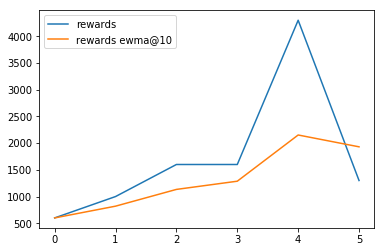

  6%|▌         | 584/10000 [02:24<38:50,  4.04it/s]

In [ ]:
for i in trange(5000):
    sess.run(train_step, sample_batch())

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

### "Final" evaluation

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=20)

print("Final mean reward", np.mean(final_rewards))

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

### POMDP setting

The Atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this.

__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [ ]:
class SimpleRecurrentAgent:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv2 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.flatten = Flatten()
            self.hid = Dense(128, activation='elu')

            self.rnn0 = tf.nn.rnn_cell.GRUCell(256, activation=tf.tanh)

            self.logits = Dense(n_actions)
            self.state_value = Dense(1)

            # prepare a graph for agent step
            _initial_state = self.get_initial_state(1)
            self.prev_state_placeholders = [tf.placeholder(m.dtype,
                                                           [None] + [m.shape[i] for i in range(1, m.ndim)])
                                            for m in _initial_state]
            self.obs_t = tf.placeholder('float32', [None, ] + list(obs_shape))
            self.next_state, self.agent_outputs = self.symbolic_step(
                self.prev_state_placeholders, self.obs_t)

    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""

        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)

        (prev_rnn0,) = prev_state

        # Apply recurrent neural net for one step here.
        # See docs on self.rnn0(...).
        # The recurrent cell should take the last feedforward dense layer as input.
        <YOUR CODE>

        logits = self.logits( <some layer> )
        state_value = self.state_value( <some layer> )

        new_state = [new_rnn0]

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        # feedforward agent has no state
        return [np.zeros([batch_size, self.rnn0.output_size], 'float32')]

    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        feed_dict = {self.obs_t: obs_t}
        for state_ph, state_value in zip(self.prev_state_placeholders, prev_state):
            feed_dict[state_ph] = state_value
        return sess.run([self.next_state, self.agent_outputs], feed_dict)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits),
                                         axis=-1, keepdims=True)
        return [np.random.choice(len(p), p=p) for p in policy]

In [ ]:
agent = SimpleRecurrentAgent('agent_with_memory', obs_shape, n_actions)

### Now let's train it!

In [ ]:
# A whole lot of your code here: train the new agent with GRU memory.
# - create pool
# - write loss functions and training op
# - train
# You can reuse most of the code with zero to few changes

```

```
```

```
```

```
```

```
```

```
```

```
```

```
```

```


### Homework assignment is in the second notebook: [url]